In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import sys
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import MeanIoU
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras import backend as K
from keras.layers import Layer
from tensorflow.keras import layers, Model, Input
from keras.optimizers import Adam

In [2]:
'''Load data'''
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["train"]
type_mod = ["img","mask","aug"]
dataset_aug = [[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset_aug[num] = loader.loadAug()
        num += 1

file = ["test","val"]
type_ori = ["images","masks"]
dataset = [[],[],[],[]]
num = 0
for i in file:
    for j in type_ori:
        loader = ImageLoader(i, j)
        dataset[num] = loader.loadData()
        num += 1

In [3]:
'''Define dataset'''
train_img = dataset_aug[0]
train_mask = dataset_aug[1]
train_aug = dataset_aug[2]

test_img = dataset[0]
test_mask = dataset[1]
val_img = dataset[2]
val_mask = dataset[3]

In [4]:
import random

'''
(1) Set the seed
(2) Generate a random permutation of indices
(3) Use the same random indices for sampling both arrays
'''

def sampling(img, mask, seed, percentage=0.2):
    sample_size = int(len(img) * percentage)
    random.seed(seed)
    random_indices = random.sample(range(len(img)), sample_size)
    sample_img = img[random_indices]
    sample_mask = mask[random_indices]

    return sample_img, sample_mask

sam_val_img, sam_val_mask = sampling(val_img, val_mask, 4)
sam_test_img, sam_test_mask = sampling(test_img, test_mask, 7)

print(sam_val_mask.shape)
print(sam_test_mask.shape)
print(np.unique(sam_test_mask))

(6415, 64, 64)
(6415, 64, 64)
[0 1 2 3 4 5 6 7]


In [5]:
'''Define variable to run the model'''
# X = np.concatenate((mod_train_img, mod_train_aug), axis=0)
# y = np.concatenate((mod_train_mask, mod_train_mask), axis=0)
X = train_img
y = train_mask
X_val = sam_val_img
y_val = sam_val_mask

In [6]:
n_classes = 8
from keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [7]:
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation

# Source:
# https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py


IMAGE_ORDERING = 'channels_last'

if IMAGE_ORDERING == 'channels_first':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.2/" \
                     "resnet50_weights_th_dim_ordering_th_kernels_notop.h5"
elif IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.2/" \
                     "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"


def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=224,  input_width=224,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000, channels=3):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D(
        (7, 7), data_format=IMAGE_ORDERING, name='avg_pool')(x)
    # f6 = x

    if pretrained == 'imagenet':
        weights_path = tf.keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

In [8]:
activation = 'relu'
def Conv2DBlock(input_tensor, filters, kernel_size):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x
    
def usegnet_resnet50(n_classes, encoder, l1_skip_conn=True, input_height=64,
          input_width=64, channels=3):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = Conv2DBlock(o, 512, 3) #4,4,512

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o) #8,8,512
    
    o = Conv2DBlock(o, 512, 3)
    o = Conv2DBlock(o, 512, 3)
    o = Conv2DBlock(o, 256, 3)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o) #16,16,256
    
    o = Conv2DBlock(o, 256, 3)
    o = Conv2DBlock(o, 256, 3)
    o = Conv2DBlock(o, 128, 3)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o) #32,32,128

    o = Conv2DBlock(o, 128, 3)
    o = Conv2DBlock(o, 64, 3)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o) #64,64,64
    o = (concatenate([o, img_input], axis=-1))
    o = (Conv2D(64, (3, 3), padding='same' , activation='relu', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same', data_format=IMAGE_ORDERING)(o)

    outputs = Activation("softmax")(o)
         
    model = Model(inputs=[img_input], outputs=[outputs])

    return model

In [9]:
model = usegnet_resnet50(8, get_resnet50_encoder, l1_skip_conn=True, input_height=64,
          input_width=64, channels=3)
# model.summary()

In [10]:
from keras.optimizers import Adam
import segmentation_models as sm

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', sm.metrics.iou_score])

Segmentation Models: using `tf.keras` framework.


In [11]:
start_time = time.time()
history = model.fit(X, y_cat, 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_val, y_val_cat),
                    shuffle=False)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.4f} seconds")

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1162s 2s/step - accuracy: 0.6088 - iou_score: 0.1636 - loss: 1.1081 - val_accuracy: 0.5969 - val_iou_score: 0.1883 - val_loss: 0.9808
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1136s 2s/step - accuracy: 0.7034 - iou_score: 0.2203 - loss: 0.7232 - val_accuracy: 0.6527 - val_iou_score: 0.2124 - val_loss: 0.8439
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1125s 2s/step - accuracy: 0.7189 - iou_score: 0.2342 - loss: 0.6805 - val_accuracy: 0.6740 - val_iou_score: 0.2258 - val_loss: 0.7745
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1116s 2s/step - accuracy: 0.7289 - iou_score: 0.2427 - loss: 0.6563 - val_accuracy: 0.6734 - val_iou_score: 0.2269 - val_loss: 0.8050
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1116s 2s/step - accuracy: 0.7385 - iou_score: 0.2530 - loss: 0.6278 - val_accuracy: 0.5288 - val_iou_score: 0.1892 - val_loss: 1.1527
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 1116s 2s/step - accuracy: 0.7537 - iou_score: 0.2664 - loss: 0.5920 - val_accuracy: 0.6144

In [12]:
X_test, y_test = sam_test_img, sam_test_mask
y_test_cat = to_categorical(y_test, num_classes=n_classes)
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = y_test

201/201 ━━━━━━━━━━━━━━━━━━━━ 58s 283ms/step


In [13]:
# Flatten the arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

In [14]:
#IOU

n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test, y_pred_classes)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.15664056


In [15]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Class 0', 
                                                                       'Class 1', 
                                                                       'Class 2', 
                                                                       'Class 3', 
                                                                       'Class 4', 
                                                                       'Class 5', 
                                                                       'Class 6', 
                                                                       'Class 8'])
print(report)

C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         8
     Class 1       0.10      0.09      0.09    293759
     Class 2       0.15      0.83      0.25    324962
     Class 3       0.16      0.14      0.15   1487533
     Class 4       0.23      0.62      0.34   2862958
     Class 5       0.32      0.27      0.30   7413470
     Class 6       0.82      0.54      0.65  12772966
     Class 8       0.33      0.17      0.22   1120184

    accuracy                           0.43  26275840
   macro avg       0.26      0.33      0.25  26275840
weighted avg       0.54      0.43      0.46  26275840



C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
y_test.shape

(6415, 64, 64)

In [ ]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())} # dic from class index to rgb  color
# map the index back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]
# covert back 32 chhannel mask to original shape (3 channel image)
def unadjust_mask(new_mask):
  return np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

Text(0.5, 1.0, 'Pred Mask')

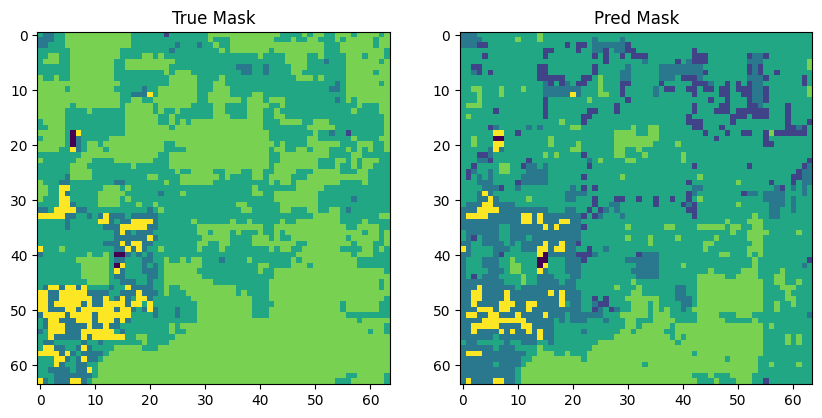

In [20]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(y_test[0])
arr[0].set_title('True Mask')
arr[1].imshow(y_pred_classes[0])
arr[1].set_title('Pred Mask')

In [51]:
original = X_test[0]
label = y_test[0]
pred = y_pred_classes[0]

In [46]:
img1 = (img1 / 8 * 255).astype(np.uint8)
img2 = (img2 / 8 * 255).astype(np.uint8)

In [47]:
_, binary1 = cv2.threshold(img1, 128, 255, cv2.THRESH_BINARY) 
_, binary2 = cv2.threshold(img2, 128, 255, cv2.THRESH_BINARY)

In [48]:
overlap = cv2.bitwise_and(binary1, binary2)

(-0.5, 63.5, 63.5, -0.5)

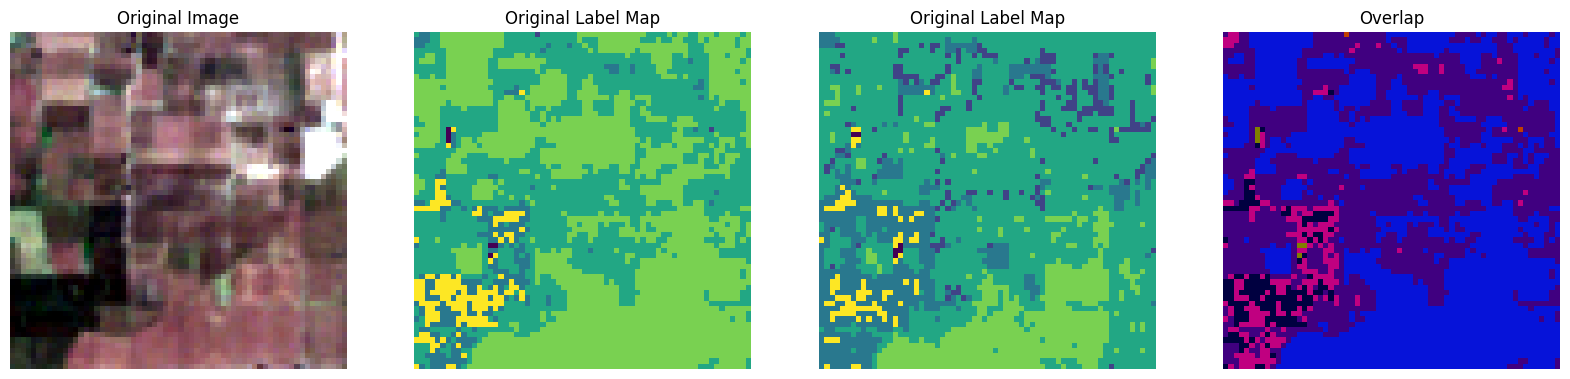

In [72]:
from matplotlib.colors import ListedColormap
# Figure Size
plt.figure(figsize=(20,10))
colors = [(128, 128, 0), 
(64, 192, 0 ), 
(0, 128, 64), 
(64, 0, 128),
(192, 0, 128),
(192, 0, 64),
(250, 237, 39),
(0, 0, 192)]

cmap = ListedColormap(colors)

# Plot Image 
plt.subplot(1, 4, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis('off')

# Plot Label Map
plt.subplot(1, 4, 2)
plt.imshow(label)
plt.title('Original Label Map')
plt.axis('off')

# Plot Label Map
plt.subplot(1, 4, 3)
plt.imshow(pred)
plt.title('Original Label Map')
plt.axis('off')

# Plot Mixed Overlap
plt.subplot(1, 4, 4)
plt.imshow(original)
plt.imshow(label, alpha=1, cmap=cmap)
plt.title("Overlap")
plt.axis('off')